In [1]:
from __init__ import *
import os
import sys
import re
import time
from scipy import sparse

import utils
import snmcseq_utils

# Configs  

In [2]:
# data directory
DATA_DIR = "./data_2mods_exc_mop_visp"
# this integration
f_results_scf_mop_visp = "./results/integration_results_scf_mop_visp.tsv"

In [3]:
# datasets
sys.path.insert(0, DATA_DIR)
from __init__datasets import *

mods_selected = [
    'smarter_cells', # MOp
    'smarter-cells-v1' # V1
    ]

# back compatible
mods_ordered = mods_selected 
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# file paths
meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')

raw_f = os.path.join(DATA_DIR, '{0}_{1}raw.npz')
raw_gene = os.path.join(DATA_DIR, '{0}_raw.gene')
raw_cell = os.path.join(DATA_DIR, '{0}_raw.cell')

## Read in data 

In [4]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

smarter_cells (4152, 11)
smarter-cells-v1 (7366, 50)


In [5]:
gxc_ftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        _mat_c = sparse.load_npz(raw_f.format(mod, 'CH_')) 
        _mat_mc = sparse.load_npz(raw_f.format(mod, 'mCH_')) 
        _gene = pd.read_csv(raw_gene.format(mod), sep='\t', header=None).iloc[:, 0].values #gene_name
        _cell = pd.read_csv(raw_cell.format(mod), sep='\t', header=None).iloc[:, 0].values 
        gxc_raw = GC_matrix(_gene, _cell, 
                                  {'c': _mat_c, 'mc': _mat_mc})
        
        base_call_cutoff = 20
        sufficient_coverage_fraction = 0.95
        # select genes covered (20 counts) in > 95% of cells
        n_gene, n_cell = gxc_raw.data['c'].shape
        gene_cov = (gxc_raw.data['c'] > base_call_cutoff).sum(axis=1)
        gene_cov = np.array(gene_cov).squeeze()/n_cell # fraction of cells covered
        cond = gene_cov>sufficient_coverage_fraction
        
        # to full matrix
        df_c = pd.DataFrame(
            gxc_raw.data['c'].tocsr()[cond, :].todense(),
            index=np.array(gxc_raw.gene)[cond],
            columns=gxc_raw.cell,
        )
        df_mc = pd.DataFrame(
            gxc_raw.data['mc'].tocsr()[cond, :].todense(),
            index=np.array(gxc_raw.gene)[cond],
            columns=gxc_raw.cell,
        )

        # compute normalized methylation matrix 
        df_mcc = utils.get_mcc_lite_v2(df_c, df_mc, base_call_cutoff=base_call_cutoff)
        gxc_ftrs[mod] = df_mcc.divide(metas[mod].loc[df_mcc.columns.values, 'mCH'], axis=1)
        del df_c, df_mc, df_mcc
        
        print(gxc_ftrs[mod].shape, time.time()-ti)
        continue
        
    f_mat = raw_f.format(mod, '')
    f_gene = raw_gene.format(mod)
    f_cell = raw_cell.format(mod)
    
    _mat = sparse.load_npz(f_mat) 
    _gene = pd.read_csv(f_gene, sep='\t', header=None).iloc[:, 0].values
    _cell = pd.read_csv(f_cell, sep='\t', header=None).iloc[:, 0].values 
    
    gxc_raw = GC_matrix(_gene, _cell, _mat)
    gxc_ftrs[mod] = snmcseq_utils.sparse_logcpm(gxc_raw, mode='logcpm')
    
    del gxc_raw, _mat
    print(gxc_ftrs[mod].data.shape, time.time()-ti)
    

smarter_cells
(23017, 4152) 4.252253293991089
smarter-cells-v1
(45768, 7366) 12.801077365875244


## Making plots

In [6]:
f = f_results_scf_mop_visp

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

print(df_info.shape)
df_info.head()

(11518, 10)


,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
LS-15395_S43_E1-50,7,9,17,30,-7.013664,10.134144,smarter_cells,SMART cells,46,L6 NP Trh
LS-15395_S44_E1-50,7,9,19,19,-9.375187,11.082741,smarter_cells,SMART cells,45,L5 NP Slc17a8
LS-15395_S46_E1-50,1,4,3,5,5.077952,7.952013,smarter_cells,SMART cells,38,L5 IT S100b_2
LS-15395_S48_E1-50,1,4,3,22,4.788595,10.278378,smarter_cells,SMART cells,38,L5 IT S100b_2
LS-15395_S50_E1-50,4,7,5,11,10.161666,4.266432,smarter_cells,SMART cells,38,L5 IT S100b_2


In [7]:
def plot_1_mod():
    """
    """
    sample_n = min(len(df_info), 20000)
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(figsize=(8,6))

        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_kws=legend_kws,
                                          kw_colors=kw_colors,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
#     return fig

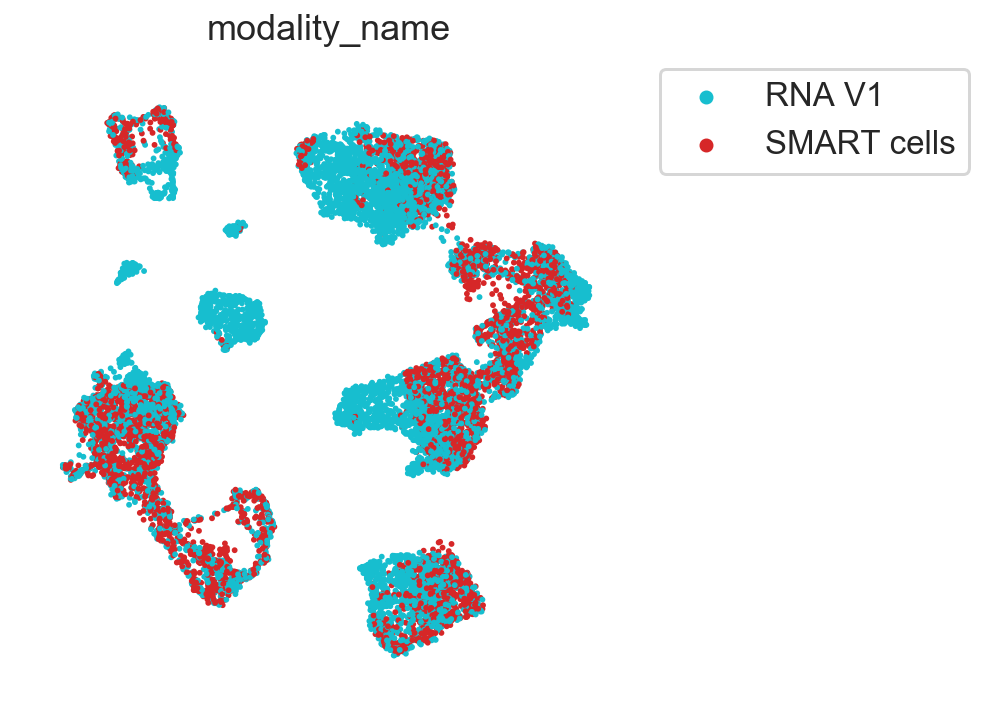

In [8]:
plot_1_mod()

In [9]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())


for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1']]
             .groupby(['cluster_joint_r1']).median())
joint_annot = df_info.groupby(['cluster_joint_r1']).agg({'annot': lambda x: x.value_counts().index.values[0]})
joint_annot.head()

,annot
cluster_joint_r1,
1,L4 IT VISp Rspo1
2,L2/3 IT VISp Agmat
3,L6 CT Grp_1
4,L6 IT VISp Penk Col27a1
5,L6 IT VISp Penk Col27a1


In [10]:
def plot_1_single(kw_colors='', show_labels=False, output=''):
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
    #                                       legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          kw_colors=kw_colors,
                                          legend_mode=-1,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        if show_labels:
            for clst, centroid in centroids['joint'].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )

#         fig.savefig(output, bbox_inches='tight', dpi=300)

In [11]:
clsts = np.sort(df_info['cluster_joint_r1'].unique())
colors = utils.gen_colors(len(clsts))
joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}
# joint_clst_colors

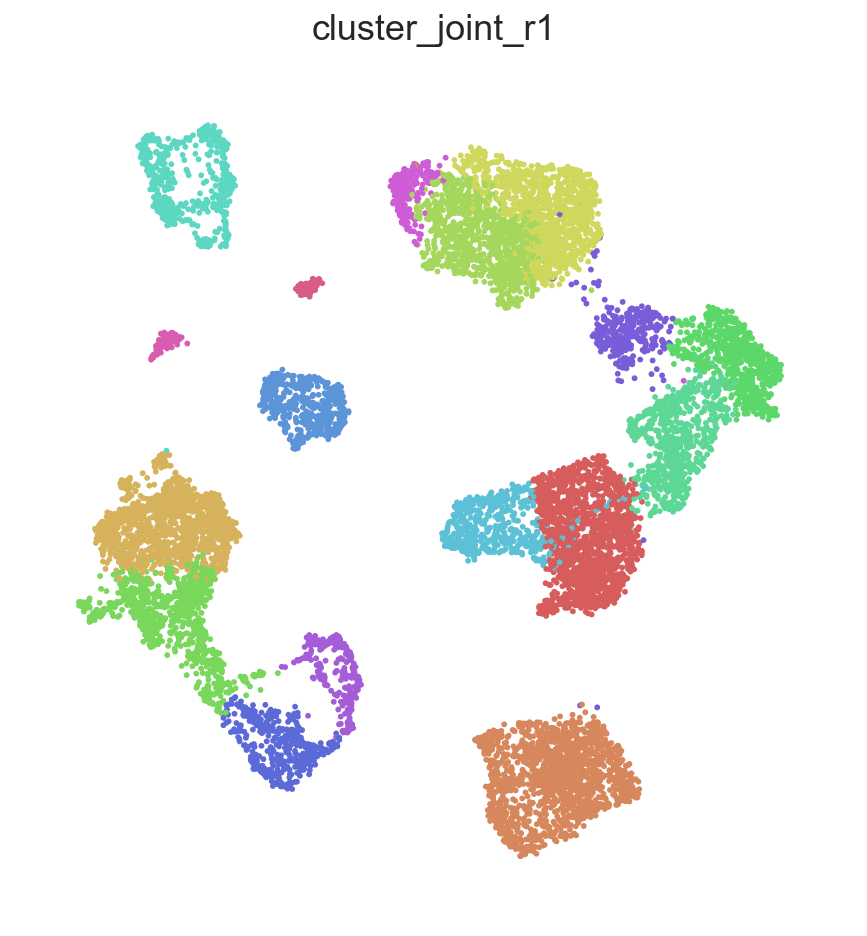

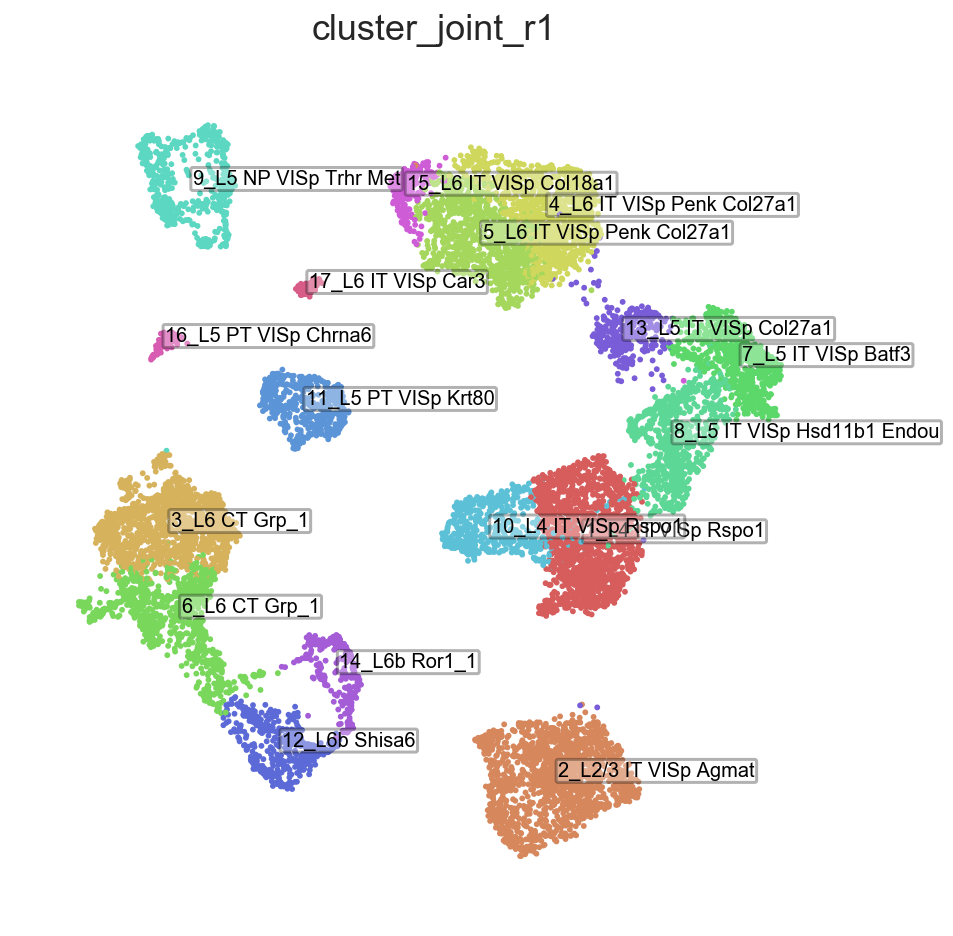

In [12]:
sample_n = 20000
plot_1_single(joint_clst_colors, show_labels=False, output='')
plot_1_single(joint_clst_colors, show_labels=True, output='')

In [13]:
def plot_gene_tsne(genes_inq, nx=len(mods_selected)):    
    with sns.plotting_context('talk'), sns.axes_style('white'):
        n = len(mods_ordered)
        nx = nx
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]

        cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])

        for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
            if settings[mod].mod_category == 'mc':
                genes = gxc_ftrs[mod].index.values
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
                gene_data = gxc_ftrs[mod].iloc[gene_idx].T
                # normalize gene_data
            else:
                genes = gxc_ftrs[mod].gene
                cells = gxc_ftrs[mod].cell
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
                gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
                gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
#                 # normalize gene_data
#                 gene_data = gene_data.applymap(lambda x: np.log10(x+1))

#             # normalize gene_data
#             gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

            df_mod = df_info[df_info['modality']==mod]
            if sample_n > len(df_mod):
                df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
            else:
                df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                             .sample(sample_n, replace=False)
                          )

            if i == 0: 
                cbar = True
            else:
                cbar = False
            utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                              s=2,
                                              cbar=cbar,
                                              cbar_ax=cbar_ax,
                                              cmap='rocket_r',
                                              rasterized=True,
                                             )
    #         ax.set_title('{} '.format(settings[mod].name, ))
            ax.set_title(genes_inq[0])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')

            for _, spine in ax.spines.items():
                spine.set_color(settings[mod].color)
                spine.set_linewidth(3)

        for ax in axs[n:]:
            ax.axis('off')
#         cbar_ax.axis('off')


        fig.subplots_adjust(hspace=0.05, wspace=0.05)
#         fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight')
        plt.show()


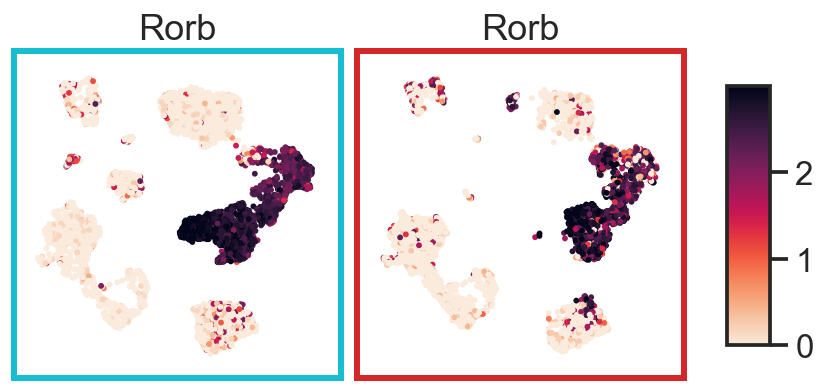

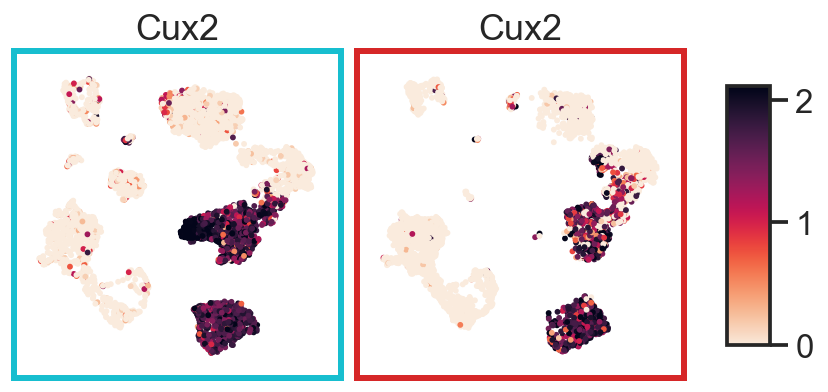

In [14]:
sample_n = 5000

genes_inq = ['Rorb']
plot_gene_tsne(genes_inq)

genes_inq = ['Cux2']
plot_gene_tsne(genes_inq)